<a href="https://colab.research.google.com/github/codebysumit/sms-spam-classifier/blob/master/sms_spam_classifier_MultinomialNB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installation Dependencies

In [ ]:
!pip install nltk
!pip install streamlit
!pip install sklearn
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install wordcloud

## Download Datasets

In [1]:
!wget 'https://github.com/codebysumit/sms-spam-classifier/raw/refs/heads/master/datasets/spam.csv'

--2025-02-11 09:06:49--  https://github.com/codebysumit/sms-spam-classifier/raw/refs/heads/master/datasets/spam.csv
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/codebysumit/sms-spam-classifier/refs/heads/master/datasets/spam.csv [following]
--2025-02-11 09:06:49--  https://raw.githubusercontent.com/codebysumit/sms-spam-classifier/refs/heads/master/datasets/spam.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 488216 (477K) [application/octet-stream]
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 476.77K  --.-KB/s    in 0.006s  

2025-02-11 09:06:50 (73.9 MB/s) - ‘spa

## Import Dependencies

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
from collections import Counter
import pickle

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score

In [4]:
import nltk
# nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
from wordcloud import WordCloud
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')

## Visualize Dataset

In [6]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')

In [7]:
df.shape

(5581, 2)

In [8]:
df.head(5572)

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


## 1. Data Cleaning

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5581 entries, 0 to 5580
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5581 non-null   object
 1   v2      5581 non-null   object
dtypes: object(2)
memory usage: 87.3+ KB


In [10]:
# To get raw for given columns that containts null value for given columns
# non_null_value = df[df['column-name'].notnull()]

In [11]:
# rename the columns name
df = df.rename(columns={'v1':'catagory', 'v2':'massage'})
df.sample(6)

,catagory,massage
4750,spam,Your weekly Cool-Mob tones are ready to downlo...
5265,ham,Gud ni8.swt drms.take care
535,ham,"Good afternoon, my love! How goes that day ? I..."
4681,ham,"Haha yeah, 2 oz is kind of a shitload"
4456,ham,Aight should I just plan to come up later toni...
4688,ham,"Didn't try, g and I decided not to head out"


- 0 => ham
- 1 => spam

In [12]:
# encodings labels value
encoder = LabelEncoder()
df['catagory'] = encoder.fit_transform(df['catagory'])

In [13]:
df.head(6)

,catagory,massage
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
5,1,FreeMsg Hey there darling it's been 3 week's n...


In [14]:
# Find missing values
df.isnull().sum()

,0
catagory,0
massage,0


In [15]:
# find duplicate values
df.duplicated().sum()

401

In [16]:
# remove duplicate values
df = df.drop_duplicates(keep='first')

In [17]:
df.duplicated().sum()

0

In [18]:
df.shape

(5180, 2)

## 2. EDA

In [19]:
df.head()

,catagory,massage
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [20]:
# 0 => ham
# 1 => spam

df['catagory'].value_counts()

,count
catagory,
0,4517
1,663


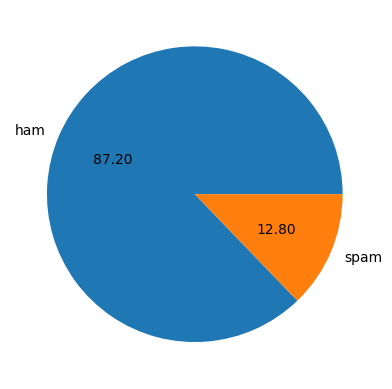

In [21]:
plt.pie(df['catagory'].value_counts(), labels=['ham', 'spam'], autopct='%0.2f')
plt.show()

# Data is imbalanced

In [22]:
# number of characters
df['num_characters'] = df['massage'].apply(len)

df.head()

,catagory,massage,num_characters
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


In [23]:
# num of words
df['num_words'] = df['massage'].apply(lambda x:len(nltk.word_tokenize(x)))
df.head()

,catagory,massage,num_characters,num_words
0,0,"Go until jurong point, crazy.. Available only ...",111,24
1,0,Ok lar... Joking wif u oni...,29,8
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37
3,0,U dun say so early hor... U c already then say...,49,13
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15


In [24]:
df['num_sentences'] = df['massage'].apply(lambda x:len(nltk.sent_tokenize(x)))
df.head()

,catagory,massage,num_characters,num_words,num_sentences
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [25]:
df[['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,5180.000000,5180.000000,5180.000000
mean,79.641699,18.602124,1.972201
std,58.486763,13.381570,1.456321
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,61.000000,15.000000,1.000000
75%,119.250000,26.000000,2.000000
max,910.000000,220.000000,38.000000


In [26]:
# ham
df[df['catagory'] == 0][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,4517.000000,4517.000000,4517.000000
mean,71.052690,17.268762,1.826212
std,56.708767,13.574367,1.392643
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,53.000000,13.000000,1.000000
75%,92.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [27]:
# spam
df[df['catagory'] == 1][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,663.000000,663.000000,663.000000
mean,138.158371,27.686275,2.966817
std,29.838700,7.007629,1.491805
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


<Axes: xlabel='num_characters', ylabel='Count'>

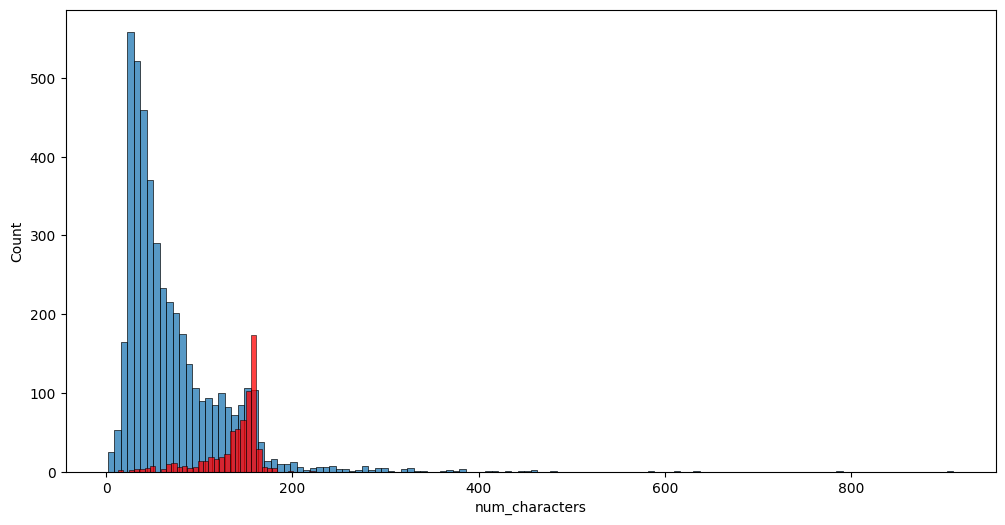

In [28]:
plt.figure(figsize=(12,6))
sns.histplot(df[df['catagory'] == 0]['num_characters'])
sns.histplot(df[df['catagory'] == 1]['num_characters'],color='red')

<Axes: xlabel='num_words', ylabel='Count'>

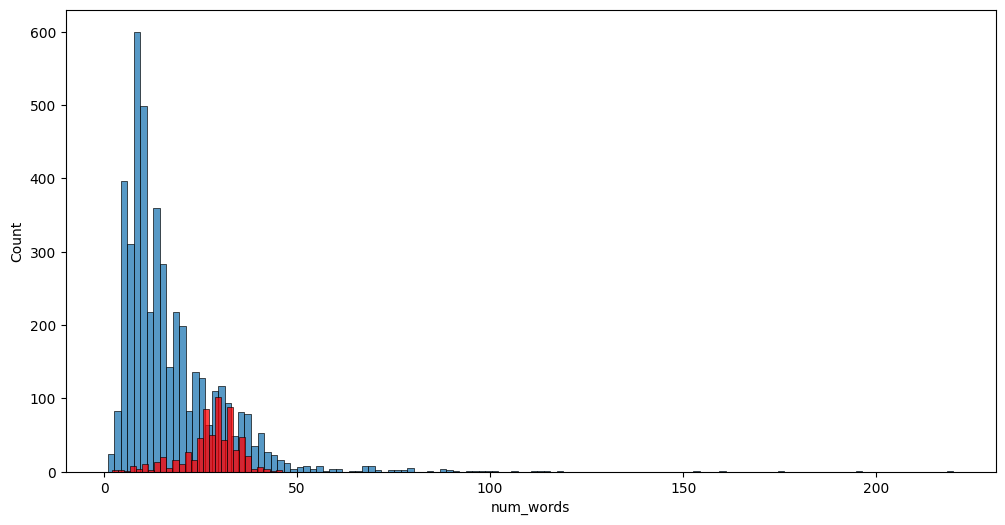

In [29]:
plt.figure(figsize=(12,6))
sns.histplot(df[df['catagory'] == 0]['num_words'])
sns.histplot(df[df['catagory'] == 1]['num_words'],color='red')

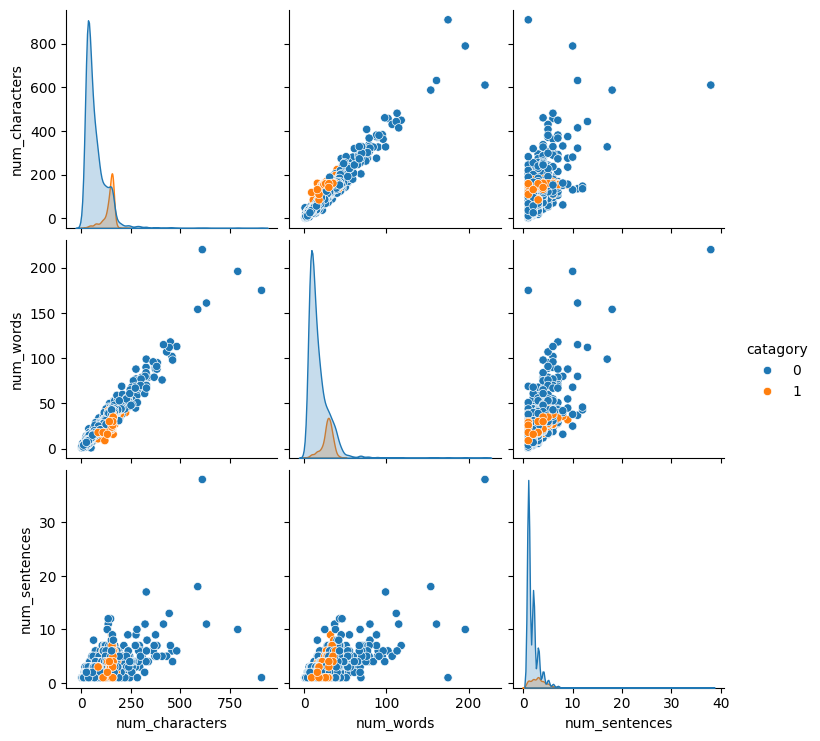

In [30]:
sns.pairplot(df,hue='catagory')

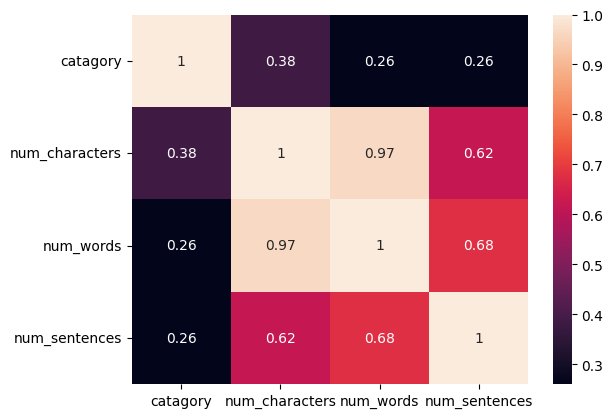

In [31]:
# Calculate the correlation matrix only for numerical features
numerical_features = df.select_dtypes(include=np.number).columns
correlation_matrix = df[numerical_features].corr()

# Generate the heatmap
sns.heatmap(correlation_matrix, annot=True)
plt.show()

## 3. Data Preprocessing

- Lower case
- Tokenization
- Removing special characters
- Removing stop words and punctuation
- Stemming

In [32]:
def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)

    y = []
    for i in text:
        if i.isalnum():
            y.append(i)

    text = y[:]
    y.clear()

    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)

    text = y[:]
    y.clear()

    ps = PorterStemmer() # Initialize PorterStemmer here
    for i in text:
        y.append(ps.stem(i))


    return " ".join(y)

In [33]:
transform_text('''\ER ENJOYIN INDIANS AT THE MO..yeP. SaLL gOoD HehE ;> hows bout u shexy? Pete Xx\""''')

'enjoyin indian mo yep sall good hehe how bout u shexi pete xx'

In [34]:
df['massage'][2458]

"Cool, I'll text you when I'm on the way"

In [35]:
ps = PorterStemmer()
ps.stem('playing')

'play'

In [36]:
df['transformed_text'] = df['massage'].apply(transform_text)

df.head()

,catagory,massage,num_characters,num_words,num_sentences,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


In [37]:
spam_wc = wc.generate(df[df['catagory'] == 1]['transformed_text'].str.cat(sep=" "))

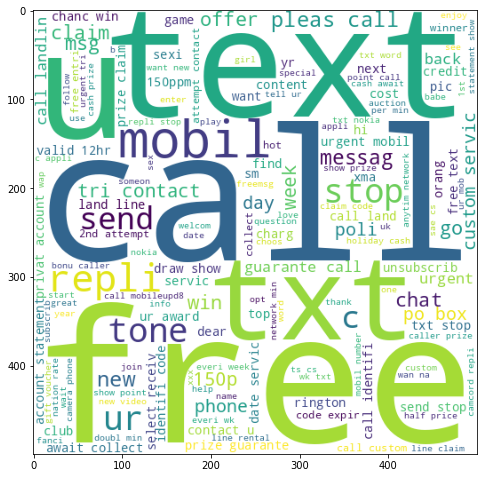

In [38]:
plt.figure(figsize=(30, 8), dpi=72)
plt.imshow(spam_wc)

In [ ]:
ham_wc = wc.generate(df[df['catagory'] == 0]['transformed_text'].str.cat(sep=" "))

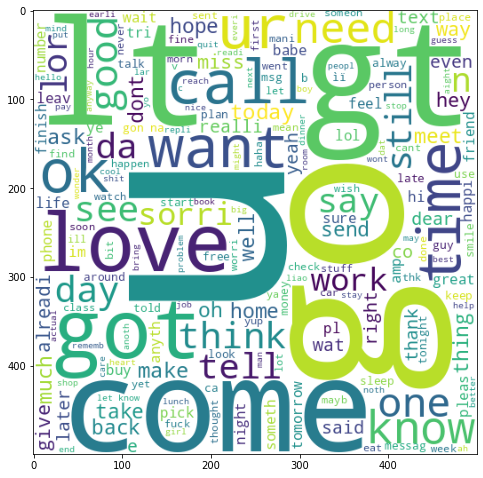

In [ ]:
plt.figure(figsize=(30,8), dpi=72)
plt.imshow(ham_wc)

In [39]:
df.head()

,catagory,massage,num_characters,num_words,num_sentences,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


In [40]:
spam_corpus = []
for msg in df[df['catagory'] == 1]['transformed_text'].tolist():
    for word in msg.split():
        spam_corpus.append(word)

In [41]:
spam_corpus

['free',
 'entri',
 '2',
 'wkli',
 'comp',
 'win',
 'fa',
 'cup',
 'final',
 'tkt',
 '21st',
 'may',
 'text',
 'fa',
 '87121',
 'receiv',
 'entri',
 'question',
 'std',
 'txt',
 'rate',
 'c',
 'appli',
 '08452810075over18',
 'freemsg',
 'hey',
 'darl',
 '3',
 'week',
 'word',
 'back',
 'like',
 'fun',
 'still',
 'tb',
 'ok',
 'xxx',
 'std',
 'chg',
 'send',
 'rcv',
 'winner',
 'valu',
 'network',
 'custom',
 'select',
 'receivea',
 'prize',
 'reward',
 'claim',
 'call',
 'claim',
 'code',
 'kl341',
 'valid',
 '12',
 'hour',
 'mobil',
 '11',
 'month',
 'u',
 'r',
 'entitl',
 'updat',
 'latest',
 'colour',
 'mobil',
 'camera',
 'free',
 'call',
 'mobil',
 'updat',
 'co',
 'free',
 '08002986030',
 'six',
 'chanc',
 'win',
 'cash',
 '100',
 'pound',
 'txt',
 'csh11',
 'send',
 'cost',
 '6day',
 'tsandc',
 'appli',
 'repli',
 'hl',
 '4',
 'info',
 'urgent',
 '1',
 'week',
 'free',
 'membership',
 'prize',
 'jackpot',
 'txt',
 'word',
 'claim',
 '81010',
 'c',
 'lccltd',
 'pobox',
 '4403ldnw

In [42]:
len(spam_corpus)

10078

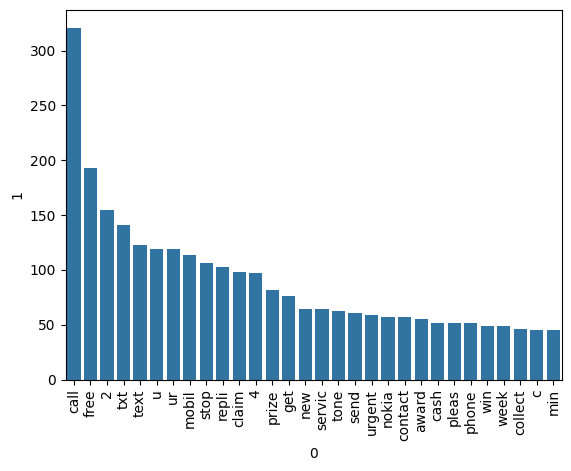

In [43]:
sns.barplot(x=pd.DataFrame(Counter(spam_corpus).most_common(30))[0], y=pd.DataFrame(Counter(spam_corpus).most_common(30))[1])
plt.xticks(rotation='vertical')
plt.show()

In [44]:
ham_corpus = []
for msg in df[df['catagory'] == 0]['transformed_text'].tolist():
    for word in msg.split():
        ham_corpus.append(word)

In [45]:
len(ham_corpus)

35709

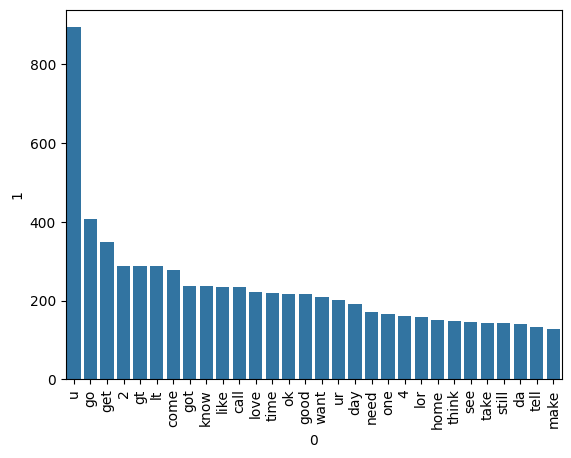

In [46]:
sns.barplot(x=pd.DataFrame(Counter(ham_corpus).most_common(30))[0],y=pd.DataFrame(Counter(ham_corpus).most_common(30))[1])
plt.xticks(rotation='vertical')
plt.show()

In [47]:
# Text Vectorization
# using Bag of Words
df.head()

,catagory,massage,num_characters,num_words,num_sentences,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


## Create Model

In [48]:
tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(df['transformed_text']).toarray()

In [49]:
X.shape

(5180, 3000)

In [50]:
y = df['catagory'].values

In [51]:
y.shape

(5180,)

**Split Datasets**

In [52]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)

**MultinomialNB**

In [53]:
mnb = MultinomialNB()

**Train Model**

In [54]:
mnb.fit(X_train,y_train)

MultinomialNB()

In [55]:
y_pred = mnb.predict(X_test)
print("Accuracy Score:", accuracy_score(y_test,y_pred))
print("Confusion Matrix:", confusion_matrix(y_test,y_pred))
print("Precision Score:", precision_score(y_test,y_pred))

Accuracy Score: 0.9700772200772201
Confusion Matrix: [[903   0]
 [ 31 102]]
Precision Score: 1.0


## Save Model

In [56]:
pickle.dump(tfidf,open('vectorizer.pkl','wb'))
pickle.dump(mnb,open('model.pkl','wb'))

## Testing and Prediction

In [57]:
tfidfv = pickle.load(open('vectorizer.pkl','rb'))
model = pickle.load(open('model.pkl','rb'))

In [68]:
input_sms = "Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030" #@param{type:'string'}

In [69]:
# 1. preprocess
transformed_sms = transform_text(input_sms)

# 2. vectorize
vector_input = tfidfv.transform([transformed_sms])

# 3. predict
result = model.predict(vector_input)[0]


if result == 1:
    print("Spam")
else:
    print("Not Spam")

Spam
